## LOB Model Exploration 

Baseline model (RF) performance: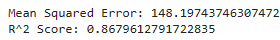

## Contents

- Load Data
- Pre-process Data
- Train Test Split
- XGBoost
- Evaluation

## Load Data

In [3]:
#import required libraries
import pandas as pd

In [4]:
#load lob csv
lob = pd.read_csv('lob.csv')

In [5]:
#dataset dimensions
lob.shape

(1037853, 15)

In [6]:
lob.head()

,Timestamp,Date,Exchange,Bid,Ask,Mid_Price,SMA_Short,SMA_Long,EMA_Short,EMA_Long,RSI,Upper_BB,Lower_BB,Volume,OBV
0,1.333,2025-01-02,Exch0,"[[1, 6]]","[[800, 1]]",400.5,NaN,NaN,400.500000,400.500000,NaN,NaN,NaN,7,0
1,1.581,2025-01-02,Exch0,"[[1, 6]]","[[799, 1]]",400.0,NaN,NaN,400.409091,400.480392,NaN,NaN,NaN,7,-7
2,1.643,2025-01-02,Exch0,"[[1, 6]]","[[798, 1]]",399.5,NaN,NaN,400.243802,400.441945,NaN,NaN,NaN,7,-14
3,1.736,2025-01-02,Exch0,"[[261, 1], [1, 6]]","[[798, 1]]",529.5,NaN,NaN,423.744929,405.503046,NaN,NaN,NaN,8,-6
4,1.984,2025-01-02,Exch0,"[[261, 1], [1, 6]]","[[797, 1]]",529.0,NaN,NaN,442.882214,410.346063,NaN,NaN,NaN,8,-14


In [7]:
#dataset info
lob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037853 entries, 0 to 1037852
Data columns (total 15 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Timestamp  1037853 non-null  float64
 1   Date       1037853 non-null  object 
 2   Exchange   1037853 non-null  object 
 3   Bid        1037853 non-null  object 
 4   Ask        1037853 non-null  object 
 5   Mid_Price  1037853 non-null  float64
 6   SMA_Short  1037844 non-null  float64
 7   SMA_Long   1037804 non-null  float64
 8   EMA_Short  1037853 non-null  float64
 9   EMA_Long   1037853 non-null  float64
 10  RSI        948874 non-null   float64
 11  Upper_BB   1037834 non-null  float64
 12  Lower_BB   1037834 non-null  float64
 13  Volume     1037853 non-null  int64  
 14  OBV        1037853 non-null  int64  
dtypes: float64(9), int64(2), object(4)
memory usage: 118.8+ MB


## Pre-process Data

In [8]:
#drop exchange
lob = lob.drop('Exchange', axis=1)

In [9]:
#copied from Felix
#ensure 'Timestamp' is treated as a number
lob['Timestamp'] = pd.to_numeric(lob['Timestamp'])
#sort the DataFrame by date and Timestamp to ensure it's in chronological order
lob.sort_values(by=['Date','Timestamp'], inplace=True)

In [10]:
#future mid-price as target
lob['Mid_Price_Future'] = lob['Mid_Price'].shift(-1) 

In [11]:
lob.head()

,Timestamp,Date,Bid,Ask,Mid_Price,SMA_Short,SMA_Long,EMA_Short,EMA_Long,RSI,Upper_BB,Lower_BB,Volume,OBV,Mid_Price_Future
0,1.333,2025-01-02,"[[1, 6]]","[[800, 1]]",400.5,NaN,NaN,400.500000,400.500000,NaN,NaN,NaN,7,0,400.0
1,1.581,2025-01-02,"[[1, 6]]","[[799, 1]]",400.0,NaN,NaN,400.409091,400.480392,NaN,NaN,NaN,7,-7,399.5
2,1.643,2025-01-02,"[[1, 6]]","[[798, 1]]",399.5,NaN,NaN,400.243802,400.441945,NaN,NaN,NaN,7,-14,529.5
3,1.736,2025-01-02,"[[261, 1], [1, 6]]","[[798, 1]]",529.5,NaN,NaN,423.744929,405.503046,NaN,NaN,NaN,8,-6,529.0
4,1.984,2025-01-02,"[[261, 1], [1, 6]]","[[797, 1]]",529.0,NaN,NaN,442.882214,410.346063,NaN,NaN,NaN,8,-14,299.5


In [26]:
#nulls?

#null_counts = lob.isnull().sum()
#print(null_counts)

#total_nulls = lob.isnull().sum().sum()
#print(f"Total null values in the DataFrame: {total_nulls}")

In [16]:
#interpolate RSI nulls
lob['RSI'] = lob['RSI'].interpolate(method='linear')

In [20]:
#interpolate SMA nulls
lob['SMA_Short'] = lob['SMA_Short'].interpolate(method='linear')
lob['SMA_Long'] = lob['SMA_Long'].interpolate(method='linear')

In [22]:
#intepolate BB nulls
lob['Upper_BB'] = lob['Upper_BB'].interpolate(method='linear')
lob['Lower_BB'] = lob['Lower_BB'].interpolate(method='linear')

In [24]:
#drop any remaining rows with nulls
lob = lob.dropna()

In [29]:
#parsing highest bid, lowest ask, and calc the spread from bid ask 
import ast 

#convert string to lists
lob['Bid'] = lob['Bid'].apply(ast.literal_eval)
lob['Ask'] = lob['Ask'].apply(ast.literal_eval)

#extract features
lob['Highest_Bid'] = lob['Bid'].apply(lambda x: max([b[0] for b in x]))
lob['Lowest_Ask'] = lob['Ask'].apply(lambda x: min([a[0] for a in x]))
lob['Spread'] = lob['Lowest_Ask'] - lob['Highest_Bid']

In [30]:
lob.columns

Index(['Timestamp', 'Date', 'Bid', 'Ask', 'Mid_Price', 'SMA_Short', 'SMA_Long',
       'EMA_Short', 'EMA_Long', 'RSI', 'Upper_BB', 'Lower_BB', 'Volume', 'OBV',
       'Mid_Price_Future', 'Highest_Bid', 'Lowest_Ask', 'Spread'],
      dtype='object')

In [31]:
#scale
from sklearn.preprocessing import StandardScaler

features_to_scale = ['Highest_Bid', 'Lowest_Ask', 'Spread', 'Mid_Price', 'SMA_Short', 'SMA_Long',
                     'EMA_Short', 'EMA_Long', 'RSI', 'Upper_BB', 'Lower_BB', 'Volume', 'OBV',
                     'Mid_Price_Future']

#initialize
scaler = StandardScaler()

#scale
lob[features_to_scale] = scaler.fit_transform(lob[features_to_scale])

In [32]:
#convert to datetime
lob['Date'] = pd.to_datetime(lob['Date'])

#extract dow (0=monday, 6=sunday)
lob['Day_of_Week'] = lob['Date'].dt.dayofweek

In [33]:
lob.head()

,Timestamp,Date,Bid,Ask,Mid_Price,SMA_Short,SMA_Long,EMA_Short,EMA_Long,RSI,Upper_BB,Lower_BB,Volume,OBV,Mid_Price_Future,Highest_Bid,Lowest_Ask,Spread,Day_of_Week
49,9.393,2025-01-02,"[[266, 6], [261, 1], [260, 11], [178, 15]]","[[273, 1], [274, 1], [276, 3], [277, 10], [282...",-1.236126,-1.252057,-0.455227,-1.271119,-0.315911,-1.034173,-0.931881,-1.047618,-0.044525,1.532773,-1.254595,-1.365428,-0.893067,-0.251272,3
50,9.424,2025-01-02,"[[266, 6], [261, 1], [260, 11], [178, 15]]","[[272, 1], [273, 1], [276, 3], [277, 10], [282...",-1.254592,-1.263752,-0.568838,-1.284128,-0.362478,-1.034173,-0.932164,-1.065418,-0.044525,1.532712,-1.273061,-1.365428,-0.916206,-0.275782,3
51,9.517,2025-01-02,"[[266, 6], [261, 1], [260, 11], [178, 15]]","[[271, 5], [272, 1], [273, 1], [276, 3], [277,...",-1.273059,-1.277395,-0.682448,-1.298365,-0.408086,-1.034173,-0.935406,-1.082625,-0.044525,1.532651,-1.273061,-1.365428,-0.939345,-0.300291,3
52,9.641,2025-01-02,"[[266, 6], [261, 1], [260, 11], [259, 1], [178...","[[271, 5], [272, 1], [273, 1], [276, 3], [277,...",-1.273059,-1.289090,-0.795626,-1.310014,-0.451906,-1.034173,-0.938615,-1.097857,0.019066,1.532651,-1.273061,-1.365428,-0.939345,-0.300291,3
53,9.672,2025-01-02,"[[266, 6], [261, 1], [260, 11], [259, 1], [178...","[[271, 5], [272, 1], [273, 1], [276, 3], [277,...",-1.273059,-1.298835,-1.021119,-1.319544,-0.494008,-1.034173,-0.944015,-1.109647,0.019066,1.532651,-1.291528,-1.365428,-0.939345,-0.300291,3


In [34]:
#mid price future outliers
#calc Q1, Q3, and IQR
Q1 = lob['Mid_Price_Future'].quantile(0.25)
Q3 = lob['Mid_Price_Future'].quantile(0.75)
IQR = Q3 - Q1

#outlier critieria
outliers_criteria = ((lob['Mid_Price_Future'] < (Q1 - 1.5 * IQR)) | (lob['Mid_Price_Future'] > (Q3 + 1.5 * IQR)))

#filter 
outliers = lob[outliers_criteria]

#print("Number of mid_price outliers detected-", outliers.shape[0])
#print("Percentage of dataset:", (outliers.shape[0]/len(lob)))

In [35]:
#remove outliers
lob = lob[~outliers_criteria]

In [36]:
lob.head()

,Timestamp,Date,Bid,Ask,Mid_Price,SMA_Short,SMA_Long,EMA_Short,EMA_Long,RSI,Upper_BB,Lower_BB,Volume,OBV,Mid_Price_Future,Highest_Bid,Lowest_Ask,Spread,Day_of_Week
49,9.393,2025-01-02,"[[266, 6], [261, 1], [260, 11], [178, 15]]","[[273, 1], [274, 1], [276, 3], [277, 10], [282...",-1.236126,-1.252057,-0.455227,-1.271119,-0.315911,-1.034173,-0.931881,-1.047618,-0.044525,1.532773,-1.254595,-1.365428,-0.893067,-0.251272,3
50,9.424,2025-01-02,"[[266, 6], [261, 1], [260, 11], [178, 15]]","[[272, 1], [273, 1], [276, 3], [277, 10], [282...",-1.254592,-1.263752,-0.568838,-1.284128,-0.362478,-1.034173,-0.932164,-1.065418,-0.044525,1.532712,-1.273061,-1.365428,-0.916206,-0.275782,3
51,9.517,2025-01-02,"[[266, 6], [261, 1], [260, 11], [178, 15]]","[[271, 5], [272, 1], [273, 1], [276, 3], [277,...",-1.273059,-1.277395,-0.682448,-1.298365,-0.408086,-1.034173,-0.935406,-1.082625,-0.044525,1.532651,-1.273061,-1.365428,-0.939345,-0.300291,3
52,9.641,2025-01-02,"[[266, 6], [261, 1], [260, 11], [259, 1], [178...","[[271, 5], [272, 1], [273, 1], [276, 3], [277,...",-1.273059,-1.289090,-0.795626,-1.310014,-0.451906,-1.034173,-0.938615,-1.097857,0.019066,1.532651,-1.273061,-1.365428,-0.939345,-0.300291,3
53,9.672,2025-01-02,"[[266, 6], [261, 1], [260, 11], [259, 1], [178...","[[271, 5], [272, 1], [273, 1], [276, 3], [277,...",-1.273059,-1.298835,-1.021119,-1.319544,-0.494008,-1.034173,-0.944015,-1.109647,0.019066,1.532651,-1.291528,-1.365428,-0.939345,-0.300291,3


## Train Test Split

In [37]:
#set split point (as timeseries)
split_point = int(len(lob) * 0.8) 

#split 
train = lob.iloc[:split_point]
test = lob.iloc[split_point:]

X_train = train.drop(['Mid_Price_Future', 'Date', 'Bid', 'Ask'], axis=1)  # Drop non-feature columns
y_train = train['Mid_Price_Future']

X_test = test.drop(['Mid_Price_Future', 'Date', 'Bid', 'Ask'], axis=1)  # Drop non-feature columns
y_test = test['Mid_Price_Future']

## XGBoost

In [40]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

#initialize and train
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)

#initial evaluation for comparison to baseline
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}, R-squared: {r2}')

MSE: 0.12514040060514497, R-squared: 0.14859841523988682


The xgb MSE is much lower than the MSE in the baseline model, which means the predictions from the xgbresults are much closer to the actual values on average.
However, the xgb R² is much lower than the R² in the baseline model, indicating that the baseline model explains a much larger proportion of the variance in the dependent variable.

## Evaluation

In [45]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)

In [46]:
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))

In [48]:
import numpy as np
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [49]:
adjusted_r2 = 1 - (1-r2_score(y_test, y_pred)) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

In [50]:
from sklearn.metrics import explained_variance_score
explained_variance = explained_variance_score(y_test, y_pred)

In [51]:
from sklearn.metrics import max_error
max_error = max_error(y_test, y_pred)

In [53]:
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'Adjusted R2: {adjusted_r2}')
print(f'Explained variance: {explained_variance}')
print(f'Max error: {max_error}')

MAE: 0.2844078704362013
RMSE: 0.35375189130963663
MAPE: 86.83060883802824
Adjusted R2: 0.14853379828715707
Explained variance: 0.550757834344854
Max error: 2.485425181066331


Given the range of Mid_Price_Future from 133.5 to 557:

MAE (Mean Absolute Error) of 0.284: This is relatively small compared to the range of the target variable. So on average, the predictions are off by less than one unit.

RMSE (Root Mean Squared Error) of 0.354: Like MAE, this value is small relative to the range of the data, suggesting that the model's predictions are generally close to the actual values. However, RMSE being higher than MAE suggests the presence of some larger errors. 

MAPE (Mean Absolute Percentage Error) of 86.83%: This seems quite high and could indicate that for some predictions, the error is large relative to the actual value. Given the wide range of the Mid_Price_Future, this high percentage could be influenced by actual values that are low relative to the range (as percentage errors are inflated when the actual values are small).

Adjusted R² of 0.1485: This suggests that only about 14.85% of the variance in the future mid-price is explained by the model, which is not very high. 

Explained Variance of 0.551: This tells us that the model explains a bit more than half of the variance of the target variable, which is ok but definitely room for improvement.

Max Error of 2.485: The largest individual error is approximately 2.5 units, which is minor compared to the range of the target variable.

Considering these metrics and the range of the target variable, it seems the model has a relatively low error in terms of absolute units. However, the high MAPE and the relatively low R² suggest there are instances where the model is not predicting as accurately as desired, or there are predictions that are significantly off as a percentage of the actual values.

We need to consider the distribution of errors- I think within the financial world consistent errors across the range of predictions would be generally more acceptable than a model that performs well on average but has occasional but significant mispredictions.(? I think)

In [43]:
#pip install shap

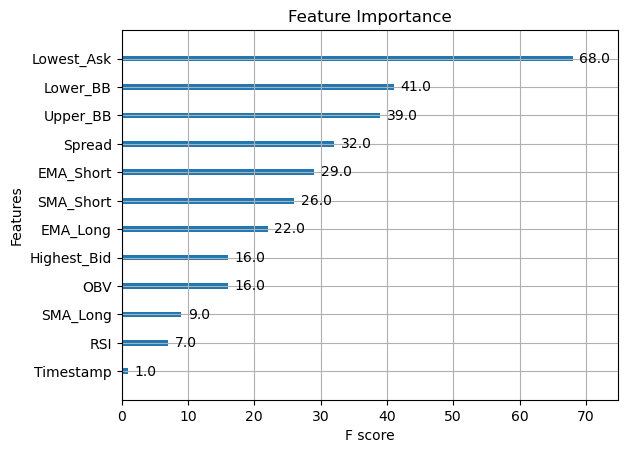

OSError: [WinError 127] The specified procedure could not be found. Error loading "C:\Users\s_sta\anaconda3\lib\site-packages\torch\lib\c10_cuda.dll" or one of its dependencies.

In [44]:
import matplotlib.pyplot as plt

#feature importances
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [ ]:
#think I need to reinstall SHAP

'Lowest_Ask' is the most important feature for the model, with the highest F score, so it was used most frequently to make splits when building the trees.

'Lower_BB' (Lower Bollinger Band) and 'Upper_BB' (Upper Bollinger Band) also have high importance scores, suggesting that these features are significant in the prediction of the target variable, possibly because they capture the volatility and price bounds well.(?I think)

'Spread', 'EMA_Short' (Short-term Exponential Moving Average), and 'SMA_Short' (Short-term Simple Moving Average) are moderately important.

'Timestamp' and 'RSI' (Relative Strength Index) have the lowest importance scores,so these features contribute less to the decisions made by the model. The low score for 'Timestamp' aligns with expectations.
trust and transparency when putting models into production or making significant decisions based on their output.

So now some more FE and try to improve the performance. 